In [1]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve, SpecialFunctions
using ForwardDiff: jacobian, derivative

In [2]:
gr(fmt = :png);

# Model specification

In [3]:
N_ks = (10, 10)  # number of firms per quality group H and L
q = range(1.2, 1.3, length = length(N_ks)) 

N = sum(N_ks)
K = length(N_ks) # number of quality types
cohorts = (N, ) # cohorts
b_bar = length(cohorts) # number of cohorts
f = fill(1/(N+1), (N+1)); # awareness set distribution

In [4]:
σ = 0.15 # baseline value calibrated from main paper
κ = 3.5 # baseline value calibrated from main paper
params = (cohorts = cohorts, Γ_bar = gamma(1-σ*(κ-1))^(1/(1-κ)) , Ω = 1.0, q = q, σ = σ, κ = κ, mc = 1.0, N_ks = N_ks)

(cohorts = (20,), Γ_bar = 0.865600495724366, Ω = 1.0, q = 1.2:0.1:1.3, σ = 0.15, κ = 3.5, mc = 1.0, N_ks = (10, 10))


# Demand function with 2-type firms

In [5]:
k = 1 # the quality type firm i belongs to
p = fill(1.0, K); # K-vector of prices

### Demand with 2-type under a single cohort

Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. An awareness set can be represented as $n = (N_L, N_H)$ where $N_L$ and $N_H$ denote the number of firms awared from $L$ and $H$ types respectively.

Given the awareness set $n$, firm $i$ on $H$ type faces demand
$$
y_{i}(p_i, p_{-i}, f) 
=  \bar{\Gamma}^{1-\kappa}\Omega \, q_H^{1/\sigma}p_i^{-1/\sigma - 1}\, \cdot 
\sum_{n \in \mathcal{N} } f_n   \sum_{n_H =1}^n  
\dfrac{n_H}{N_H}  \dfrac{\binom{N_H}{n_H} \binom{N_L}{n - n_H}}{\binom{N_H + N_L}{n}}
\left( 
n_H \left( \dfrac{p_{H}}{q_{H}}   \right)^{-1/\sigma} +  
(n - n_H) \left( \dfrac{p_{L}}{q_{L}}   \right)^{-1/\sigma} +
\dfrac{p_i^{-1/\sigma} - p^{-1/\sigma}_{H} }{ q_H^{-1/\sigma }} 
\right)  
$$

In [6]:
# Demand function with 2-type under a single cohort
# p_i: the price of product of firm i (can be different from p[k])
# k: the qualtity type firm i belongs to
# p: K-vector of prices across firms
# f: awareness set distribution on 1:(N+1)
# params: model parameters
# n: awareness set in 1:(N+1)
# n_k: number of k-type firms awared such that n_k <= n
function demand_summand(p_i, k, p, f, params, n, n_k)
    @unpack cohorts, q, σ, N_ks = params
    N = sum(N_ks)
    k_other = k == 1 ? 2 : 1
    
    weight = (n_k / N_ks[k]) * (binomial(N_ks[k], n_k) * binomial(N_ks[k_other], n - n_k) / binomial(N, n))
    proportions_scaled = [p[k] / q[k]; p[k_other] / q[k_other]].^(-1/σ)
    return weight * (sum([n_k; n - n_k] .* proportions_scaled) + (p_i^(-1/σ) - p[k]^(-1/σ)) / (q[k])^(-1/σ))
end

function demand(p_i, k, p, f, params)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ = params
    f = reshape(f, Tuple(fill(0:N, length(cohorts))))
    demand_value = 0

    # only first cohort
    for n in CartesianIndices(f)
        if (n[1] > 0)
            demand_value += f[n] * sum((n_k -> demand_summand(p_i, k, p, f, params, n[1], n_k)).(1:n[1]))
        end
    end
    return Γ_bar^(1-κ)*Ω*q[k]^(1/σ)*p_i^(-1/σ-1) * demand_value
end

profit(p_i, k, p, f, params) = (p_i - params.mc) * demand(p_i, k, p, f, params)
profit_derivative(p_i, k, p, f, params) = derivative(p_i -> profit(p_i, k, p, f, params), p_i)

profit_derivative (generic function with 1 method)

## Plots

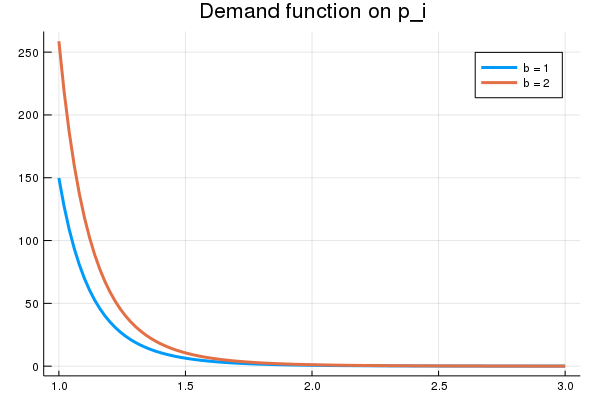

In [7]:
# plot the demand function
plot(range(1.0,stop=3.0,length=100), (k -> (p_i -> demand(p_i, k, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Demand function on p_i")

In [8]:
# confirm that the demand function is decreasing in price
@assert all(diff((p_i -> demand(p_i, k, p, f, params)).(1:100)) .<= 0)

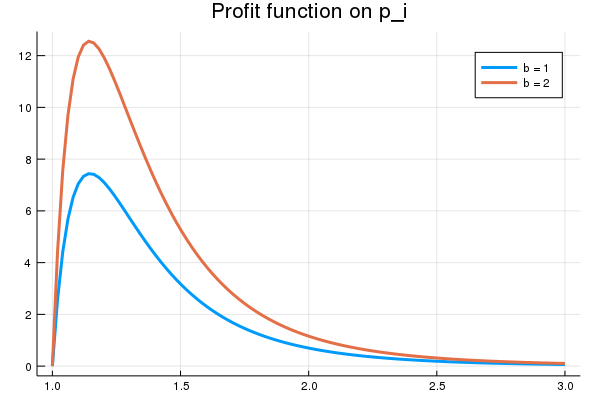

In [9]:
# plot the profit function
plot(range(1.0,stop=3.0,length=100), (k -> (p_i -> profit(p_i, k, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i")

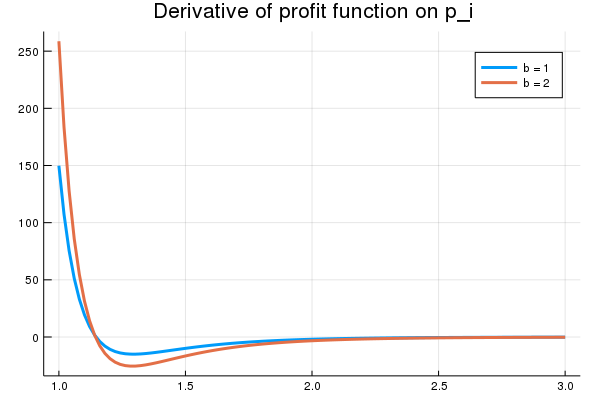

In [10]:
# plot the profit derivative function
plot(range(1.0,stop=3.0,length=100), (k -> (p_i -> profit_derivative(p_i, k, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Derivative of profit function on p_i")

# Nash equilibria

In [11]:
function D_p(p, f, params)
    # K-vector of cohorts where ith element represents ith firms' cohort
    ks = 1:length(params.N_ks)
    # return the vector of derivatives
    return [profit_derivative(p[k], ks[k], p, f, params) for k in eachindex(p)]
end

function nash_equilibrium(f, params; autodiff=:forward, iv = fill(params.mc, length(params.N_ks)))
    sol = nlsolve(p -> D_p(p, f, params), iv, autodiff = autodiff)
    return (p = sol.zero, converged = converged(sol), solution = sol)
end

nash_equilibrium (generic function with 1 method)

In [12]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 1.1423904185411078
 1.13728251117973  

## Plots

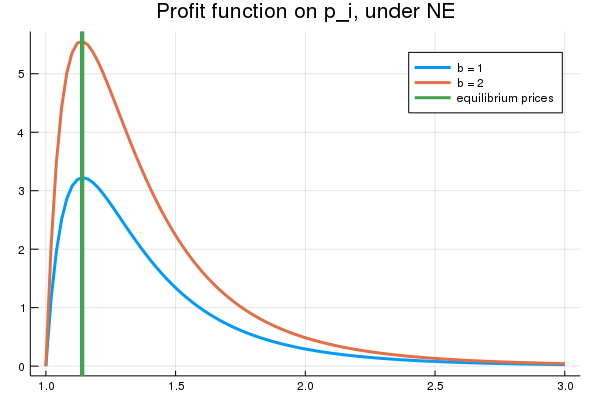

In [13]:
plot(range(1.0,stop=3.0,length=100), (k -> (p_i -> profit(p_i, k, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")

## Plots (all firms are awared)

In [14]:
f = [fill(.0, N); 1]

21-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [15]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 1.1447222414652602
 1.1410395052755544

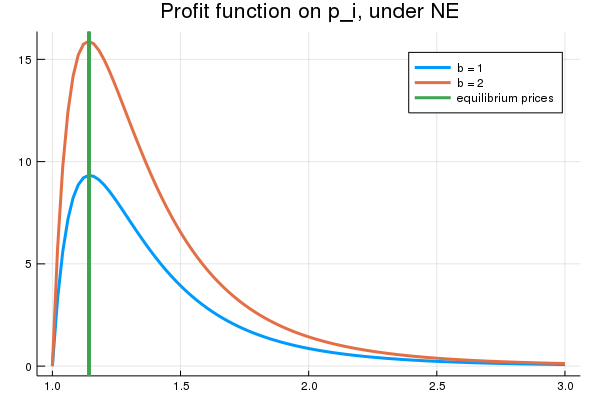

In [16]:
plot(range(1.0,stop=3.0,length=100), (k -> (p_i -> profit(p_i, k, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")

## Plots (with more firms for each type)

In [17]:
N_ks = (20, 20) # number of firms per type
N = sum(N_ks)
cohorts = (N, ) # cohorts
f = fill(1/(N+1), N+1); # awareness set distribution
params = merge(params, (cohorts = cohorts, N_ks = N_ks))

(cohorts = (40,), Γ_bar = 0.865600495724366, Ω = 1.0, q = 1.2:0.1:1.3, σ = 0.15, κ = 3.5, mc = 1.0, N_ks = (20, 20))

In [18]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 1.146028210091237 
 1.1432924262320951

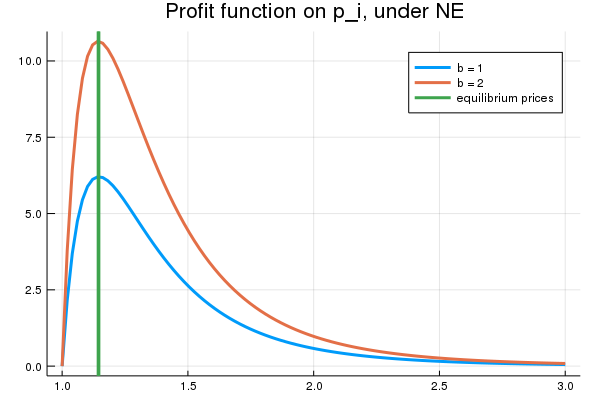

In [19]:
plot(range(1.0,stop=3.0,length=100), (k -> (p_i -> profit(p_i, k, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")